In [0]:
train_path = ".kaggle/competitions/si650winter11/training.txt"
test_path = ".kaggle/competitions/si650winter11/testdata.txt"

In [75]:
from keras.layers import Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import collections
import os

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0

In [0]:
ftrain = open(train_path, 'rb')
count = 0
for line in ftrain:
  line = line.decode('ascii', 'ignore').lower()
  label, sentence = line.strip().split('\t')
  words = nltk.word_tokenize(sentence)
  if len(words) > maxlen:
    maxlen = len(words)
  
  for word in words:
    word_freqs[word] += 1
  num_recs += 1

ftrain.close()

In [78]:
print(maxlen)
print(len(word_freqs))

42
2313


In [0]:
MAX_SENTENCE_LENTGH = 40
MAX_FEATURES = 2000


vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {c[0]: i for i, c in enumerate(word_freqs.most_common(MAX_FEATURES), start=2)}

word2index["PAD"] = 0
word2index["UNK"] = 1

index2word = {v: k for k, v in word2index.items()}

In [0]:
x = np.empty((num_recs, ), dtype=list)
y = np.empty((num_recs, ))

i = 0
ftrain = open(train_path, 'rb')

for line in ftrain:
  line = line.decode('ascii', 'ignore').lower()
  label, sentence = line.strip().split('\t')
  words = nltk.word_tokenize(sentence)
  seqs = []
  for word in words:
    if word in word2index:
      seqs.append(word2index[word])
    else:
      seqs.append(word2index["UNK"])
      
  x[i] = seqs
  y[i] = int(label)
  i += 1
    
ftrain.close()

x = sequence.pad_sequences(x, maxlen=MAX_SENTENCE_LENTGH)

In [81]:
for i in x[0]:
  print(index2word[i] + ' ', end='')

PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD the da vinci code book is just awesome . 

In [82]:
y[0]

1.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=MAX_SENTENCE_LENTGH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 25s 4ms/step - loss: 0.2282 - acc: 0.9067 - val_loss: 0.0689 - val_acc: 0.9788
Epoch 2/10
5668/5668 [==============================] - 18s 3ms/step - loss: 0.0305 - acc: 0.9915 - val_loss: 0.0428 - val_acc: 0.9845
Epoch 3/10
1952/5668 [=========>....................] - ETA: 10s - loss: 0.0078 - acc: 0.9974

5668/5668 [==============================] - 18s 3ms/step - loss: 0.0096 - acc: 0.9975 - val_loss: 0.0352 - val_acc: 0.9908
Epoch 4/10
5668/5668 [==============================] - 18s 3ms/step - loss: 0.0037 - acc: 0.9986 - val_loss: 0.0542 - val_acc: 0.9873
Epoch 5/10
4704/5668 [=======================>......] - ETA: 2s - loss: 0.0057 - acc: 0.9983

5668/5668 [==============================] - 18s 3ms/step - loss: 0.0065 - acc: 0.9979 - val_loss: 0.0631 - val_acc: 0.9866
Epoch 6/10
5668/5668 [==============================] - 18s 3ms/step - loss: 0.0048 - acc: 0.9995 - val_loss: 0.0594 - val_acc: 0.9873
Epoch 7/10
5312/5668 [===========================>..] - ETA: 1s - loss: 0.0025 - acc: 0.9998

5668/5668 [==============================] - 18s 3ms/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.0665 - val_acc: 0.9866
Epoch 8/10
5668/5668 [==============================] - 18s 3ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0649 - val_acc: 0.9845
Epoch 9/10
5440/5668 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 0.9993

5668/5668 [==============================] - 18s 3ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0615 - val_acc: 0.9880
Epoch 10/10
5668/5668 [==============================] - 18s 3ms/step - loss: 3.2163e-04 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9859


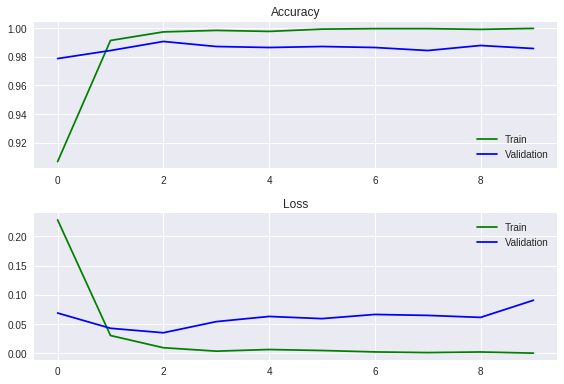

In [88]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history['acc'], color='g', label='Train')
plt.plot(history.history['val_acc'], color='b', label='Validation')
plt.legend(loc='best')

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history['loss'], color='g', label='Train')
plt.plot(history.history['val_loss'], color='b', label='Validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [89]:
score, acc = model.evaluate(x_test, y_test, batch_size=32)
print("Test score : ", score)
print("Test accuracy : ", acc)

1418/1418 [==============================] - 1s 1ms/step
Test score :  0.09079404146080972
Test accuracy :  0.9858956276445698


In [91]:
for i in range(5):
  idx = np.random.randint(len(x_test))
  xtest = x_test[idx].reshape(1, 40)
  ylabel = y_test[idx]
  ypred = model.predict(x_test)[0][0]
  sentence = " ".join([index2word[i] for i in xtest[0].tolist() if i != 0])
  print("%.0ft%dt%s" % (ypred, ylabel, sentence))

1t0ti hate harry potter , that daniel wotshisface needs a fucking slap ...
1t1tthe da vinci code was absolutely awesome !
1t1tmission impossible 3 was excellent .
1t0tthe da vinci code sucked big time .
1t0tthe da vinci code sucked balls .


In [0]:
ftest = open(test_path, 'rb')

num_recs_test = 0
seqs = []

for line in ftest:
  line = line.decode('ascii', 'ignore').lower()
  sentence = line.strip()
  words = nltk.word_tokenize(sentence)
  seq = []
  for word in words:
    if word in word2index:
      seq.append(word2index[word])
    else:
      seq.append(word2index["UNK"])
  
  seqs.append(seq)
  num_recs_test += 1

ftest.close()

test_x = np.empty((num_recs_test, ), dtype=list)

for i in range(num_recs_test):
  test_x[i] = seqs[i]
  
  
test_x = sequence.pad_sequences(test_x, maxlen=MAX_SENTENCE_LENTGH)

In [0]:
preds = model.predict(test_x)

In [103]:
preds.shape

(33052, 1)

In [0]:
with open('submission.txt', 'w') as f:
  for pred in preds:
    if pred > 0.5:
      f.write("1\n")
    else:
      f.write("0\n")

In [0]:
from google.colab import files

files.download("submission.txt")